In [49]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import Rectangle
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import torch
from torchvision import transforms
from tqdm import tqdm
from detectron2.structures import ImageList

from compile_and_profile.compile_profile_inference_aihub import prepare_data

image_dir = Path('./compile_and_profile/images/default')
annotation_path = Path('./compile_and_profile/annotations/instances_default.json')
coco = COCO(annotation_path)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


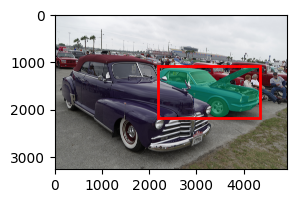

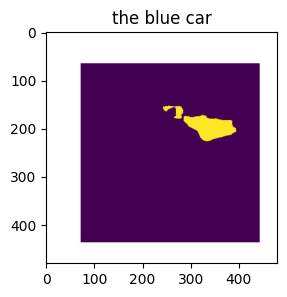

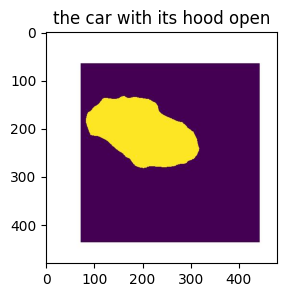

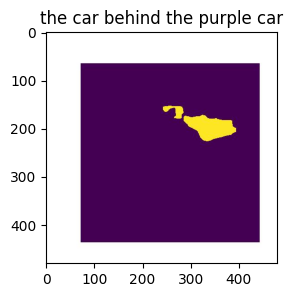

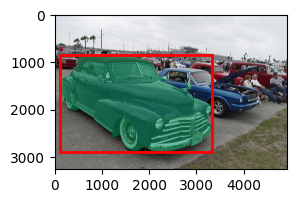

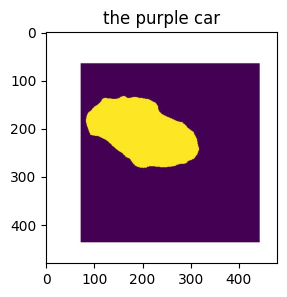

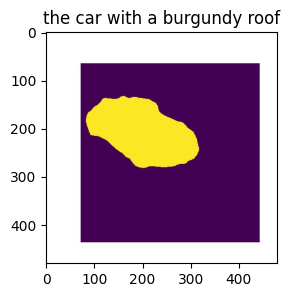

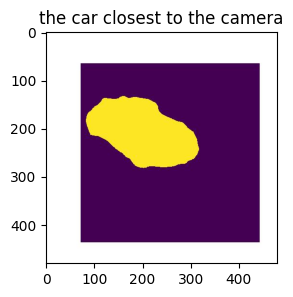

In [ ]:
def show_image_and_annotation(image_id: int):
    image = coco.imgs[image_id]
    image_path = "./compile_and_profile/images/default" / Path(f"{image['file_name']}")
    img = np.asarray(Image.open(image_path))

    for ann_id in coco.getAnnIds([image_id]):
        annotation = coco.anns[ann_id]
        texts = [v for v in annotation['attributes'].values() if isinstance(v, str) and len(v) > 0]
        plt.figure(figsize=(3, 3))
        ax = plt.gca()

        bbox = annotation['bbox']
        box_plot = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(box_plot)
        ax.imshow(img)
        coco.showAnns([annotation])
        for i, text in enumerate(texts):
            plt.figure(figsize=(3, 3))
            ax = plt.gca()
            output_img_path = output_dir / 'images' / f"{image['file_name'].replace(' ', '_')}_{ann_id}_{text.replace(' ', '_')}.jpg"
            output_img = np.asarray(Image.open(output_img_path))
            ax.imshow(output_img)
            ax.set_title(text)

show_image_and_annotation(3)